In [2]:
import io
import numpy as np
from tqdm import tqdm
import tifffile as tf
from PIL import Image
import zarr
from scipy.spatial import cKDTree
import pandas as pd
import ome_types
import gc
import math
import tifffile
import numpy as np
from loguru import logger

segmentation_path = "/Users/swarchol/Research/exemplar-001/segmentation/unmicst-exemplar-001/nuclei.ome.tif"
csv_path = "/Users/swarchol/Research/exemplar-001/quantification/exemplar-001--unmicst_cell_umap_7_22.csv"
image_path = "/Users/swarchol/Research/exemplar-001/registration/exemplar-001.ome.tif"
cut_seg_cells = zarr.open("/Users/swarchol/Research/exemplar-001/cellcutter/cut_mask")
cut_cells = zarr.open("/Users/swarchol/Research/exemplar-001/cellcutter/cut")



output_tiff_path = "/Users/swarchol/Research/exemplar-001/tiled.ome.tif"  # Set the path for the new OME-TIFF file
output_segmentation_path = "/Users/swarchol/Research/exemplar-001/tiled-mask.ome.tif"  # New segmentation output path




In [9]:
# @profile
def get_points_in_rect(kdtree, rect_points):
    center = np.mean(rect_points, axis=1)
    y_range, x_range = rect_points
    x_range = np.sort(x_range)
    y_range = np.sort(y_range)
    nearest_neighbor = kdtree.query(center, k=1)[1]
    nearest_neighbor_location = kdtree.data[nearest_neighbor].flatten()
    if (
        nearest_neighbor_location[1] < x_range[0]
        or nearest_neighbor_location[1] > x_range[1]
    ):
        return None
    if (
        nearest_neighbor_location[0] < y_range[0]
        or nearest_neighbor_location[0] > y_range[1]
    ):
        return None

    return nearest_neighbor


In [10]:


# Open the image as a Zarr array
imgio =  tf.TiffFile(image_path, is_ome=False) 
im_zarr = zarr.open(imgio.series[0].aszarr())

segio = tf.TiffFile(segmentation_path, is_ome=False)
seg_zarr = zarr.open(segio.series[0].aszarr())

# Create a new MemoryStore to hold the duplicated Zarr group
memory_store = zarr.MemoryStore()
seg_memory_store = zarr.MemoryStore()

# Duplicate the Zarr group to the new MemoryStore
zarr.convenience.copy_store(im_zarr.store, memory_store)
zarr.convenience.copy_store(seg_zarr.store, seg_memory_store)
# Open the duplicated Zarr array from the MemoryStore
im_zarr_tiled = zarr.open(memory_store)
seg_zarr_tiled = zarr.open(seg_memory_store)


# Now `im_zarr_tiled` is a copy of `im_zarr` in memory

In [11]:
def create_tiled_zarr(im_zarr_tiled, cut_cells, tree, csv_df, is_segmentation=False):
    for z in range(len(im_zarr_tiled)):
        tile_size = 1024
        height, width = im_zarr_tiled[z].shape[-2:]  # Use -2 and -1 for both single and multi-channel
        scale_factor = 2**z
        
        for y in tqdm(range(0, height, tile_size)):
            for x in range(0, width, tile_size):
                tile_height = min(tile_size, height - y)
                tile_width = min(tile_size, width - x)
                
                x_tiles = tile_width // cut_cells.shape[-1]
                y_tiles = tile_height // cut_cells.shape[-1]
                
                if is_segmentation:
                    tile = np.zeros((tile_height, tile_width), dtype=np.uint16)
                else:
                    tile = np.zeros((im_zarr_tiled[z].shape[0], tile_height, tile_width), dtype=np.uint16)
                
                for i in range(x_tiles):
                    for j in range(y_tiles):
                        image_y_range = [
                            (x + int((i / x_tiles) * tile_width)) * scale_factor,
                            (x + int(((i + 1) / x_tiles) * tile_width)) * scale_factor,
                        ]
                        image_x_range = [
                            (y + int((j / y_tiles) * tile_height)) * scale_factor,
                            (y + int(((j + 1) / y_tiles) * tile_height)) * scale_factor,
                        ]

                        if image_x_range[0] >= im_zarr_tiled[0].shape[-2] or image_y_range[0] >= im_zarr_tiled[0].shape[-1]:
                            continue
                        
                        point = get_points_in_rect(tree, [image_y_range, image_x_range])
                        if point is not None:
                            sub_tile_x_range = [
                                int((i / x_tiles) * tile_width),
                                int(((i + 1) / x_tiles) * tile_width),
                            ]
                            sub_tile_y_range = [
                                int((j / y_tiles) * tile_height),
                                int(((j + 1) / y_tiles) * tile_height),
                            ]
                            
                            if is_segmentation:
                                data = cut_cells[point]
                                tile[
                                    sub_tile_y_range[0] : sub_tile_y_range[0] + data.shape[0],
                                    sub_tile_x_range[0] : sub_tile_x_range[0] + data.shape[1],
                                ] = data
                            else:
                                for c in range(im_zarr_tiled[z].shape[0]):
                                    data = cut_cells[c, point]
                                    tile[
                                        c,
                                        sub_tile_y_range[0] : sub_tile_y_range[0] + data.shape[0],
                                        sub_tile_x_range[0] : sub_tile_x_range[0] + data.shape[1],
                                    ] = data
                
                if is_segmentation:
                    im_zarr_tiled[z][y:y+tile_height, x:x+tile_width] = tile
                else:
                    im_zarr_tiled[z][:, y:y+tile_height, x:x+tile_width] = tile

    return im_zarr_tiled

In [12]:
csv_df = pd.read_csv(csv_path)
try:
    tree = cKDTree(csv_df[["UMAP_X", "UMAP_Y"]].values)
except:
    tree = cKDTree(csv_df[["emb1", "emb2"]].values)

csv_df = pd.read_csv(csv_path)

# def get_points_in_rect(kdtree, rect_points):
#     center = np.mean(rect_points, axis=1)
#     y_range, x_range = rect_points
#     x_range = np.sort(x_range)
#     y_range = np.sort(y_range)
#     nearest_neighbor = kdtree.query(center, k=1)[1]
#     nearest_neighbor_location = kdtree.data[nearest_neighbor].flatten()
#     if (nearest_neighbor_location[1] < x_range[0] or nearest_neighbor_location[1] > x_range[1]):
#         return None
#     if (nearest_neighbor_location[0] < y_range[0] or nearest_neighbor_location[0] > y_range[1]):
#         return None
#     return nearest_neighbor
# for z in range(len(im_zarr_tiled)):
#     tile_size = 1024
#     height, width = im_zarr_tiled[z].shape[1:]
#     scale_factor = 2**z
    
#     for y in tqdm(range(0, height, tile_size)):
#         for x in range(0, width, tile_size):
#             tile_height = min(tile_size, height - y)
#             tile_width = min(tile_size, width - x)
            
#             x_tiles = tile_width // cut_cells.shape[-1]
#             y_tiles = tile_height // cut_cells.shape[-1]
            
#             tile = np.zeros((im_zarr_tiled[z].shape[0], tile_height, tile_width), dtype=np.uint16)
            
#             for i in range(x_tiles):
#                 for j in range(y_tiles):
#                     image_y_range = [
#                         (x + int((i / x_tiles) * tile_width)) * scale_factor,
#                         (x + int(((i + 1) / x_tiles) * tile_width)) * scale_factor,
#                     ]
#                     image_x_range = [
#                         (y + int((j / y_tiles) * tile_height)) * scale_factor,
#                         (y + int(((j + 1) / y_tiles) * tile_height)) * scale_factor,
#                     ]

#                     if image_x_range[0] >= im_zarr_tiled[0].shape[-2] or image_y_range[0] >= im_zarr_tiled[0].shape[-1]:
#                         continue
                    
#                     point = get_points_in_rect(tree, [image_y_range, image_x_range])
#                     if point is not None:
#                         sub_tile_x_range = [
#                             int((i / x_tiles) * tile_width),
#                             int(((i + 1) / x_tiles) * tile_width),
#                         ]
#                         sub_tile_y_range = [
#                             int((j / y_tiles) * tile_height),
#                             int(((j + 1) / y_tiles) * tile_height),
#                         ]
                        
#                         for c in range(im_zarr_tiled[z].shape[0]):
#                             data = cut_cells[c, point]
#                             tile[
#                                 c,
#                                 sub_tile_y_range[0] : sub_tile_y_range[0] + data.shape[0],
#                                 sub_tile_x_range[0] : sub_tile_x_range[0] + data.shape[1],
#                             ] = data
            
#             im_zarr_tiled[z][:, y:y+tile_height, x:x+tile_width] = tile


In [13]:
import gc
import math
import tifffile
import numpy as np
from loguru import logger

class PyramidSetting:
    def __init__(self, downscale_factor=2, tile_size=1024, max_pyramid_img_size=1024):
        self.downscale_factor = downscale_factor
        self.tile_size = tile_size
        self.max_pyramid_img_size = max_pyramid_img_size

    def pyramid_shapes(self, base_shape):
        num_levels = self.num_levels(base_shape)
        factors = self.downscale_factor ** np.arange(num_levels)
        shapes = np.ceil(np.array(base_shape) / factors[:, None])
        return [tuple(map(int, s)) for s in shapes]

    def num_levels(self, base_shape):
        factor = max(base_shape) / self.max_pyramid_img_size
        return math.ceil(math.log(factor, self.downscale_factor)) + 1

def write_ome_tiff_from_zarr(
    input_tiff_path,
    zarr_group,
    output_path,
    pixel_size=1,
    channel_names=None,
    verbose=True,
    downscale_factor=2,
    compression=None,
    is_mask=False,
    tile_size=1024,
    kwargs_tifffile=None
):
    # Load the input OME-TIFF to extract metadata
    with tifffile.TiffFile(input_tiff_path) as tif:
        ome_metadata = tif.ome_metadata  # Get OME metadata
        pixel_size_x = tif.pages[0].tags['XResolution'].value[1] / tif.pages[0].tags['XResolution'].value[0]
        pixel_size_y = tif.pages[0].tags['YResolution'].value[1] / tif.pages[0].tags['YResolution'].value[0]
        base_shape = zarr_group[0].shape[1:]  # Use Zarr shape instead of input image
        num_channels = zarr_group[0].shape[0]
    
    # Use PyramidSetting to calculate the number of levels and shapes for each level
    pyramid_setting = PyramidSetting(downscale_factor=downscale_factor)
    shapes = pyramid_setting.pyramid_shapes(base_shape)
    
    # Extract number of pyramid levels from zarr group
    num_levels = len(shapes)

    # Metadata for the OME-TIFF file
    metadata = {
        "Pixels": {
            "PhysicalSizeX": pixel_size_x,
            "PhysicalSizeXUnit": "\u00b5m",
            "PhysicalSizeY": pixel_size_y,
            "PhysicalSizeYUnit": "\u00b5m",
        },
    }
    if channel_names:
        metadata["Channel"] = {"Name": channel_names}

    dtype = zarr_group[0].dtype
    software = f"OME-TIFF Pyramid Writer"
    if kwargs_tifffile is None:
        kwargs_tifffile = {}

    logger.info(f"Writing OME-TIFF to {output_path}")

    # Create OME-TIFF with pyramidal levels from Zarr data
    with tifffile.TiffWriter(output_path, bigtiff=True) as tif:
        # Write base level (highest resolution) from the Zarr array
        tif.write(
            data=zarr_group[0],
            shape=(num_channels, *shapes[0]),
            subifds=num_levels - 1,  # subifds for pyramid levels
            dtype=dtype,
            tile=(tile_size, tile_size),
            metadata=metadata,
            software=software,
            compression=compression,
            **kwargs_tifffile,
        )
        
        # Write pyramid levels from zarr
        for level in range(1, num_levels):
            level_shape = shapes[level]
            logger.info(f"    Writing pyramid level {level} with shape {level_shape}")
            tif.write(
                data=zarr_group[level],
                shape=(num_channels, *level_shape),
                subfiletype=1,  # Mark it as a reduced-resolution version
                dtype=dtype,
                tile=(tile_size, tile_size),
                compression=compression,
                **kwargs_tifffile,
            )
        logger.info(f"OME-TIFF saved to {output_path}")

# Example usage
# input_tiff_path: Path to the input OME-TIFF file.
# zarr_group: The Zarr group containing the pyramid levels.
# write_ome_tiff_from_zarr("input.ome.tiff", zarr_group, "output.ome.tiff")

In [14]:

seg_zarr_tiled = create_tiled_zarr(seg_zarr_tiled, cut_seg_cells, tree, csv_df, is_segmentation=True)
write_ome_tiff_from_zarr(segmentation_path, seg_zarr_tiled, output_segmentation_path, is_mask=True)

# im_zarr_tiled = create_tiled_zarr(im_zarr_tiled, cut_cells, tree, csv_df)
# write_ome_tiff_from_zarr(image_path, im_zarr_tiled, output_tiff_path)


100%|██████████| 1/1 [00:00<00:00, 17.24it/s]
2024-09-26 10:43:45.931 | INFO     | __main__:write_ome_tiff_from_zarr:68 - Writing OME-TIFF to /Users/swarchol/Research/exemplar-001/tiled-mask.ome.tif
2024-09-26 10:43:45.970 | INFO     | __main__:write_ome_tiff_from_zarr:88 -     Writing pyramid level 1 with shape (1256,)


ValueError: shape argument (3139, 1256) does not match data shape (1570, 1256)

In [3]:
import pandas as pd
pd_df =  pd.read_parquet('/Users/swarchol/Research/bed/data/for_simon/for_simon.parquet')

In [4]:
pd_df

,CellID,Hoechst0,Hoechst1,Hoechst2,anti_CD3,anti_CD45RO,Hoechst3,Keratin_570,aSMA_660,Hoechst4,...,Eccentricity,Solidity,Extent,Orientation,Sample,Condition,Replicate,emb1,emb2,cluster_2d
0,47,15160.563636,46937.436364,42258.036364,0.235838,0.446541,24461.163636,0.270726,0.175902,29225.363636,...,0.921447,0.916667,0.763889,-1.345788,WD-76845-097,CRC,1,8.872235,19.100700,-1
1,49,11740.781250,50723.343750,37632.750000,0.227137,0.584889,20075.703125,0.307917,0.174437,23681.062500,...,0.881066,0.888889,0.653061,-1.338040,WD-76845-097,CRC,1,8.379912,20.137026,48
2,51,9565.513514,35690.567568,27032.162162,0.200757,0.436587,14392.621622,0.223040,0.162788,16623.810811,...,0.745784,0.902439,0.685185,-1.475095,WD-76845-097,CRC,1,8.799885,19.362713,-1
3,52,7308.113636,24641.750000,19214.886364,0.228204,0.662923,9205.522727,0.272994,0.207245,11968.636364,...,0.825548,0.936170,0.571429,-1.390750,WD-76845-097,CRC,1,8.504932,20.219538,48
4,53,19249.623188,57667.202899,53509.811594,0.261224,0.704192,30691.275362,0.295741,0.296045,35399.927536,...,0.842002,0.907895,0.663462,-1.441929,WD-76845-097,CRC,1,8.576233,20.350970,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933248,1242746,18694.276596,18604.936170,17079.659574,0.248739,0.205520,6982.680851,0.136490,0.334573,9554.489362,...,0.618630,0.959184,0.839286,-0.935988,WD-76845-097,CRC,1,18.186203,2.827556,72
933249,1242748,31240.095238,34545.301587,32678.349206,0.361773,0.381520,12513.238095,0.219673,0.126889,17597.158730,...,0.828981,0.940299,0.583333,0.459917,WD-76845-097,CRC,1,11.654654,19.720820,-1
933250,1242751,45004.015873,47513.269841,44139.714286,0.229271,0.467404,16901.253968,0.152905,0.283555,20190.285714,...,0.847186,0.954545,0.630000,0.830085,WD-76845-097,CRC,1,18.262630,3.071928,72
933251,1242753,33568.983607,35640.344262,31911.131148,0.233328,0.515689,12369.524590,0.134693,0.331565,15530.245902,...,0.753467,0.953125,0.693182,-1.363981,WD-76845-097,CRC,1,19.307392,3.061911,72


In [10]:
csv_path = "/Users/swarchol/Research/exemplar-001/quantification/exemplar-001--unmicst_cell_umap_7_22.csv"
csv_df = pd.read_csv(csv_path)
print("Min and Max of UMAP_X:", csv_df['UMAP_X'].min(), csv_df['UMAP_X'].max())
print("Min and Max of UMAP_Y:", csv_df['UMAP_Y'].min(), csv_df['UMAP_Y'].max())
imgio.series[0].shape

Min and Max of UMAP_X: 0.0 2442.924
Min and Max of UMAP_Y: 0.0 3134.373


In [12]:
import tifffile as tf
image_path = "/Users/swarchol/Research/exemplar-001/registration/exemplar-001.ome.tif"
imgio =  tf.TiffFile(image_path, is_ome=False)


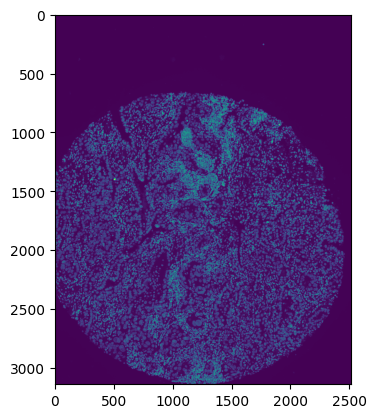

In [16]:
import matplotlib.pyplot as plt
plt.imshow(imgio.series[0].asarray()[0,:,:])

In [26]:
CUT_CELLS_PATH = "/Users/swarchol/Research/exemplar-001/cut/combined"
cut_cells = zarr.open(CUT_CELLS_PATH)

SEG_PATH = "/Users/swarchol/Research/exemplar-001/cut/mask"
seg_cells = zarr.open(SEG_PATH)

In [27]:
cut_cells

<zarr.core.Array (12, 11170, 39, 39) uint16>

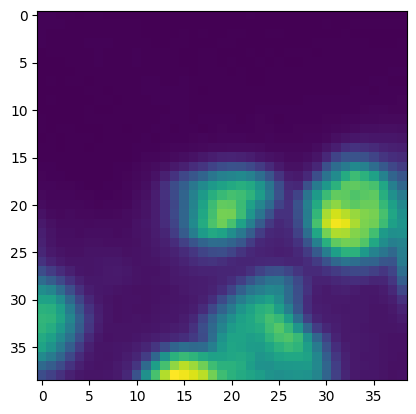

In [28]:
import matplotlib.pyplot as plt
plt.imshow(cut_cells[0, 10,:, :])

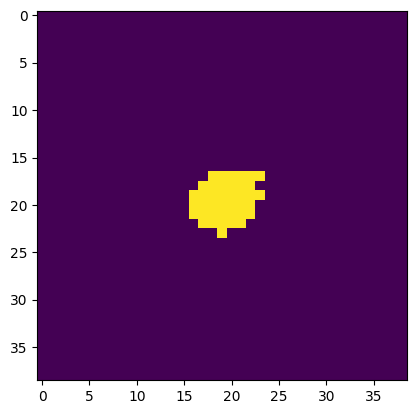

In [29]:
plt.imshow(seg_cells[10,:,:])

In [11]:
# zarr_list = [zarr.open("/mnt/c/Users/simon/Documents/Greg/for_simon/cut/"+"channel_"+str(i), mode="r") for i in range(40)]
# list all folders in /Users/swarchol/Research/exemplar-001/cut/
import os
import re
# List to store folder names and their ending numbers
folders_with_numbers = []
directory_path = "/Users/swarchol/Research/exemplar-001/cut"

# Iterate through the directory contents
for folder_name in os.listdir(directory_path):
    folder_path = os.path.join(directory_path, folder_name)
    if os.path.isdir(folder_path):
        # Extract the number at the end of the folder name
        match = re.search(r'\d+$', folder_name)
        if match:
            folders_with_numbers.append((folder_name, int(match.group())))

# Sort the folders by their ending numbers 
folders_with_numbers.sort(key=lambda x: x[1])

In [12]:
folders_with_numbers

[('channel_0', 0),
 ('channel_1', 1),
 ('channel_2', 2),
 ('channel_3', 3),
 ('channel_4', 4),
 ('channel_5', 5),
 ('channel_6', 6),
 ('channel_7', 7),
 ('channel_8', 8),
 ('channel_9', 9),
 ('channel_10', 10),
 ('channel_11', 11)]

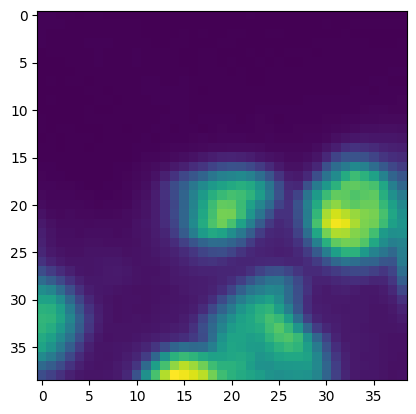

In [25]:
test = zarr.open("/Users/swarchol/Research/exemplar-001/cellcutter/cut")
plt.imshow(cut_cells[0, 10,:, :])